# Data Visualization and Description for Train Delay Prediction

## First we load the data:

Note that this is the data for one month, which, for simplicity reasons will not be entirely used during the testing of different models.

In [ ]:
# We import the useful libraries
import numpy as np
import pickle as pkl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 

# Load the data
local_path_to_data = "/Users/mac/Desktop/train_delay_prediction/delay_pred_5_5_v1/"
with open(f"{local_path_to_data}metadata/columns_scheme.pkl", "rb") as f:
  columns_scheme = pkl.load(f)
x = np.load(f"{local_path_to_data}x/x_202303.npy")
y_delays = np.load(f"{local_path_to_data}y_delays/y_delays_202303.npy")
y_actions = np.load(f"{local_path_to_data}y_actions/y_actions_202303.npy")
md = np.load(f"{local_path_to_data}metadata/md_202303.npy", allow_pickle=True)

## Description of the data:

- columns_scheme: A file which describes all of the data more clearly, especially useful in the case where the user wants to understand the features of the data points.
- x: Collection of Data Points, in our case around 1.7 million data points across around 230 features.
- y_delays: Collection of stations of our dataset, in our case, 5 stations after the current one for which we wish to predict the delay. 
- y_actions: The actions the train can take; stay in place (0), move to next station (1), move to second next station (2).
- md: Contains the state time, date of departure and train number for further descriptive information.

In [3]:
# It is useful to look at columns_scheme to understand the features
columns_scheme

{'x': {'PAST_DELAYS_5': 0,
  'PAST_DELAYS_4': 1,
  'PAST_DELAYS_3': 2,
  'PAST_DELAYS_2': 3,
  'PAST_DELAYS_1': 4,
  'PAST_TYPES_5_D': 5,
  'PAST_TYPES_4_D': 6,
  'PAST_TYPES_3_D': 7,
  'PAST_TYPES_2_D': 8,
  'PAST_TYPES_1_D': 9,
  'FUTURE_TYPES_1_D': 10,
  'FUTURE_TYPES_2_D': 11,
  'FUTURE_TYPES_3_D': 12,
  'FUTURE_TYPES_4_D': 13,
  'FUTURE_TYPES_5_D': 14,
  'PAST_TYPES_5_A': 15,
  'PAST_TYPES_4_A': 16,
  'PAST_TYPES_3_A': 17,
  'PAST_TYPES_2_A': 18,
  'PAST_TYPES_1_A': 19,
  'FUTURE_TYPES_1_A': 20,
  'FUTURE_TYPES_2_A': 21,
  'FUTURE_TYPES_3_A': 22,
  'FUTURE_TYPES_4_A': 23,
  'FUTURE_TYPES_5_A': 24,
  'PAST_TYPES_5_P': 25,
  'PAST_TYPES_4_P': 26,
  'PAST_TYPES_3_P': 27,
  'PAST_TYPES_2_P': 28,
  'PAST_TYPES_1_P': 29,
  'FUTURE_TYPES_1_P': 30,
  'FUTURE_TYPES_2_P': 31,
  'FUTURE_TYPES_3_P': 32,
  'FUTURE_TYPES_4_P': 33,
  'FUTURE_TYPES_5_P': 34,
  'PAST_STATIONS_5_embedding_0': 35,
  'PAST_STATIONS_4_embedding_0': 36,
  'PAST_STATIONS_3_embedding_0': 37,
  'PAST_STATIONS_2_embedding_

For a further understanding of the data we can look at the shape of the x and y_delay matrices.

Those are the ones we will use during our Machine Learning predictions.

In [4]:
print(f"x shape: {x.shape}")
print(f"y_delays shape: {y_delays.shape}")

x shape: (1732341, 234)
y_delays shape: (1732341, 5)


In [5]:
md[:,0].shape

(1732341,)

In [8]:
md[:1][0]

array([352330710, '01MAR2023', 10], dtype=object)

md[md[:,0] == 352330710].size # To know how many trains there are for this state time

In [ ]:
res = [] #compute an average of those
for state_time in tqdm(np.unique(md[:,0])):
    d = md[md[:,0] == state_time].shape
    res.append(d)
print(np.mean(res))

100%|██████████| 8219/8219 [02:51<00:00, 47.97it/s]

632.3181652269133


(array([1301.,  433.,  334.,  394., 3262.,  295.,  347., 1059.,  376.,
         418.]),
 array([  1.,  40.,  79., 118., 157., 196., 235., 274., 313., 352., 391.]),
 <BarContainer object of 10 artists>)

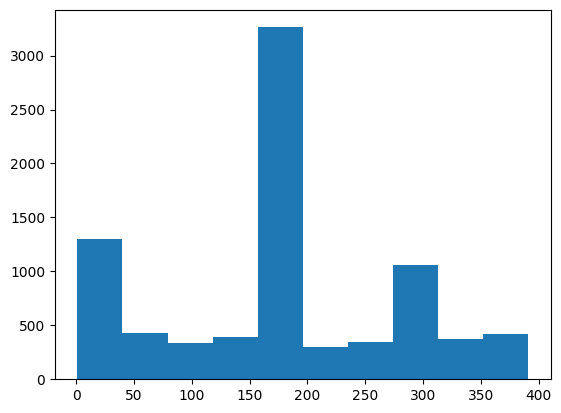

In [ ]:
plt.hist([res[i]/3 for i in res])

/var/folders/z6/_mfrnglj7h161j5389c53l_m0000gn/T/ipykernel_42459/4217203561.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates_of_departure = pd.to_datetime(md[:, 1], errors='coerce')


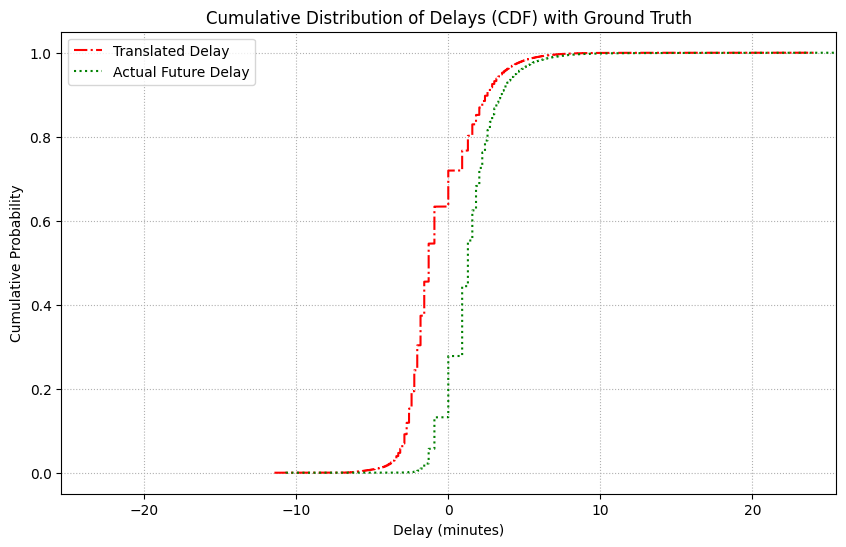

In [ ]:
dates_of_departure = pd.to_datetime(md[:, 1], errors='coerce')

df_delays = pd.DataFrame({
    "Past Delay (min)": x[:, columns_scheme['x']['PAST_DELAYS_1']],
    "Planned Arrival (min)": x[:, columns_scheme['x']['FUTURE_PLANNED_TIME_NUM_1']],
    "Future Delay (min)": y_delays[:, 0]
})

df_delays["Translated Delay (min)"] = df_delays["Past Delay (min)"] - np.maximum(0, df_delays["Past Delay (min)"] + df_delays["Planned Arrival (min)"])

df_delays = df_delays.dropna()

def compute_cdf(data):
    """Returns sorted data and corresponding cumulative probability."""
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

past_sorted, past_cdf = compute_cdf(df_delays["Past Delay (min)"])
planned_sorted, planned_cdf = compute_cdf(df_delays["Planned Arrival (min)"])
translated_sorted, translated_cdf = compute_cdf(df_delays["Translated Delay (min)"])
future_sorted, future_cdf = compute_cdf(df_delays["Future Delay (min)"])

plt.figure(figsize=(10, 6))

# plt.plot(past_sorted, past_cdf, label="Past Delay", linestyle="-", color="blue")
# plt.plot(planned_sorted, planned_cdf, label="Planned Arrival", linestyle="--", color="orange")
plt.plot(translated_sorted, translated_cdf, label="Translated Delay", linestyle="-.", color="red")
plt.plot(future_sorted, future_cdf, label="Actual Future Delay", linestyle=":", color="green") 

plt.xlabel("Delay (minutes)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of Delays (CDF) with Ground Truth")
plt.legend()
plt.grid(True, linestyle="dotted")
plt.xlim(min(past_sorted.min(), planned_sorted.min(), translated_sorted.min(), future_sorted.min()), 
         max(past_sorted.max(), planned_sorted.max(), translated_sorted.max(), future_sorted.max()))

plt.show()

## -------------------------------------------------------------------

/var/folders/z6/_mfrnglj7h161j5389c53l_m0000gn/T/ipykernel_19246/31800989.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates_of_departure = pd.to_datetime(md[:, 1], errors='coerce')


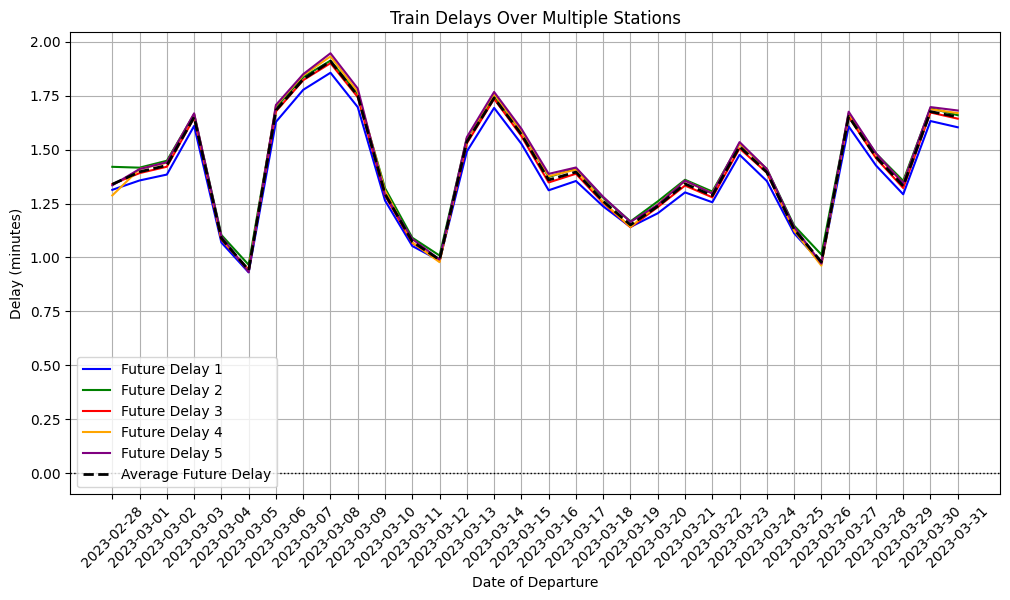

In [ ]:
dates_of_departure = pd.to_datetime(md[:, 1], errors='coerce')

df_delays = pd.DataFrame({
    "date_of_departure": dates_of_departure,
    "future_delay_1": y_delays[:, 0],
    "future_delay_2": y_delays[:, 1],
    "future_delay_3": y_delays[:, 2],
    "future_delay_4": y_delays[:, 3],
    "future_delay_5": y_delays[:, 4],
})

df_delays = df_delays.dropna()
df_grouped = df_delays.groupby("date_of_departure").mean()

df_grouped["average_future_delay"] = df_grouped[["future_delay_1", "future_delay_2", "future_delay_3", "future_delay_4", "future_delay_5"]].mean(axis=1)

plt.figure(figsize=(12, 6))

colors = ["blue", "green", "red", "orange", "purple"]
for i in range(1, 6):
    plt.plot(df_grouped.index, df_grouped[f"future_delay_{i}"], label=f"Future Delay {i}", color=colors[i-1])

plt.plot(df_grouped.index, df_grouped["average_future_delay"], label="Average Future Delay", color="black", linestyle="dashed", linewidth=2)

tick_interval = 1  # Change this to control frequency
plt.xticks(df_grouped.index[::tick_interval], rotation=45)

plt.axhline(0, color="black", linestyle="dotted", linewidth=1)
plt.xlabel("Date of Departure")
plt.ylabel("Delay (minutes)")
plt.title("Train Delays Over Multiple Stations")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/z6/_mfrnglj7h161j5389c53l_m0000gn/T/ipykernel_19246/2148622402.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates_of_departure = pd.to_datetime(md[:, 1], errors='coerce')


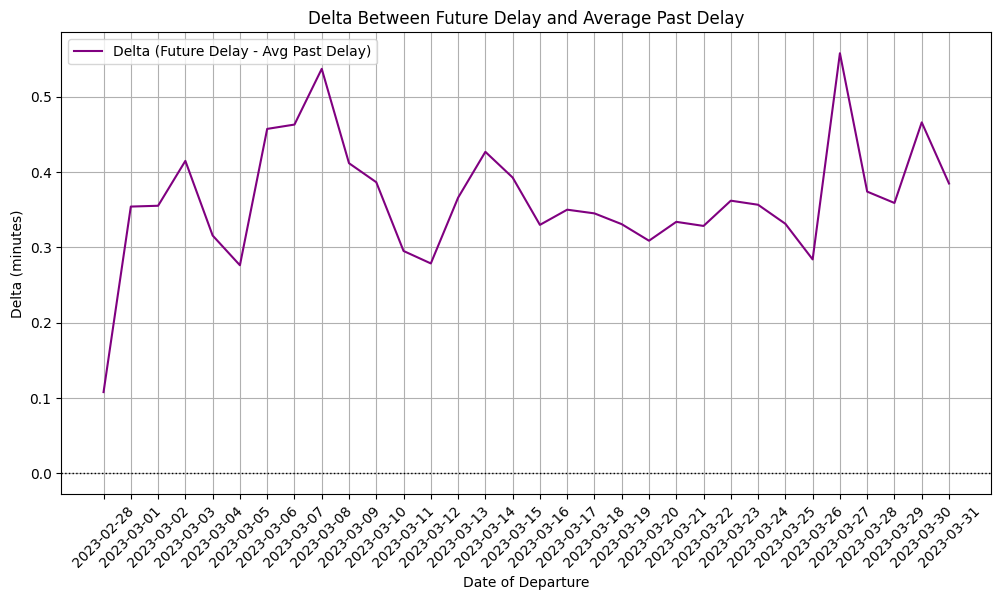

In [ ]:
dates_of_departure = pd.to_datetime(md[:, 1], errors='coerce')

df_deltas = pd.DataFrame({
    "date_of_departure": dates_of_departure,
    "future_delay_1": y_delays[:, 0],
})

past_delay_columns = [f"PAST_DELAYS_{i}" for i in range(1, 6) if f"PAST_DELAYS_{i}" in columns_scheme['x']]
for col in past_delay_columns:
    df_deltas[col] = x[:, columns_scheme['x'][col]]

df_deltas["average_past_delay"] = df_deltas[past_delay_columns].mean(axis=1)

df_deltas["delta"] = df_deltas["future_delay_1"] - df_deltas["average_past_delay"]

df_deltas = df_deltas.dropna()
df_grouped = df_deltas.groupby("date_of_departure").mean()

plt.figure(figsize=(12, 6))
plt.plot(df_grouped.index, df_grouped["delta"], label="Delta (Future Delay - Avg Past Delay)", color="purple")

tick_interval = 1  # Change this to control frequency 
plt.xticks(df_grouped.index[::tick_interval], rotation=45)

plt.axhline(0, color="black", linestyle="dotted", linewidth=1)
plt.xlabel("Date of Departure")
plt.ylabel("Delta (minutes)")
plt.title("Delta Between Future Delay and Average Past Delay")
plt.legend()
plt.grid(True)
plt.show()

### **Interpretation of Delta Graph**

1. **Positive Delta:**
   - The future delay is consistently higher than the average past delay, meaning delays **increase as the train progresses**.
   - This trend highlights the potential propagation of delays over time.

2. **High Delta Days:**
   - Significant spikes in delta are observed around:
     - **March 7**: Delta exceeds **0.5 minutes**, indicating a major delay escalation.
     - **March 26**: Another sharp rise in delta, showing abnormal delay patterns.
   - These could signal operational issues or external disruptions on these specific days.

3. **Stable Periods:**
   - Between **March 15** and **March 25**, the delta remains relatively consistent, suggesting steady train operations with minimal deviations.

4. **Conclusion:**
   - The consistent positive delta suggests a systemic issue with delay propagation.
   - Identifying days with **high deltas** can help pinpoint anomalies and potential causes, such as scheduling issues, weather, or demand surges.

**Next step:** we might be interested to look at the other features in the days where spikes in the delta arise, in order to understand the unexpected delay and try to find a better way to predict it, or model it.

## Exploratory Data Analysis

### Convert NumPy Arrays to Pandas DataFrame
To make data exploration easier, we convert the dataset to a Pandas DataFrame.

In [ ]:
df = pd.DataFrame(x, columns=columns_scheme['x'])

for i in range(y_delays.shape[1]):
    df[f'target_{i}'] = y_delays[:, i]

df.head()

,PAST_DELAYS_5,PAST_DELAYS_4,PAST_DELAYS_3,PAST_DELAYS_2,PAST_DELAYS_1,PAST_TYPES_5_D,PAST_TYPES_4_D,PAST_TYPES_3_D,PAST_TYPES_2_D,PAST_TYPES_1_D,...,year_cos_1,year_sin_2,year_cos_2,year_sin_4,year_cos_4,target_0,target_1,target_2,target_3,target_4
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.512371,0.880012,-0.474951,-0.835925,-0.548843,5.91608,6.258328,6.258328,6.324555,6.324555
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.512371,0.880012,-0.474951,-0.835925,-0.548843,5.91608,6.258328,6.258328,6.324555,6.324555
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.512371,0.880012,-0.474951,-0.835925,-0.548843,5.91608,6.258328,6.258328,6.324555,6.324555
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.512371,0.880012,-0.474951,-0.835925,-0.548843,5.91608,6.258328,6.258328,6.324555,6.324555
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.512371,0.880012,-0.474951,-0.835925,-0.548843,5.91608,6.258328,6.258328,6.324555,6.324555


### Check for Missing Values
We check for missing values to identify any data quality issues.

In [ ]:
print(df.isnull().sum())

PAST_DELAYS_5    0
PAST_DELAYS_4    0
PAST_DELAYS_3    0
PAST_DELAYS_2    0
PAST_DELAYS_1    0
                ..
target_0         0
target_1         0
target_2         0
target_3         0
target_4         0
Length: 239, dtype: int64


### Statistical Summary of Features
This provides a quick summary of numerical features in the dataset.

In [ ]:
# Basic statistics of numerical features
df.describe()

,PAST_DELAYS_5,PAST_DELAYS_4,PAST_DELAYS_3,PAST_DELAYS_2,PAST_DELAYS_1,PAST_TYPES_5_D,PAST_TYPES_4_D,PAST_TYPES_3_D,PAST_TYPES_2_D,PAST_TYPES_1_D,...,year_cos_1,year_sin_2,year_cos_2,year_sin_4,year_cos_4,target_0,target_1,target_2,target_3,target_4
count,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,...,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06,1.732341e+06
mean,9.444339e-01,9.818772e-01,1.033433e+00,1.080697e+00,1.147946e+00,4.632714e-01,4.319028e-01,4.227453e-01,3.853006e-01,4.144981e-01,...,2.686410e-01,4.979490e-01,-8.110598e-01,-7.261548e-01,3.705012e-01,1.417531e+00,1.471443e+00,1.449706e+00,1.466885e+00,1.473901e+00
std,1.508122e+00,1.537811e+00,1.562981e+00,1.595515e+00,1.631726e+00,4.986493e-01,4.953412e-01,4.939958e-01,4.866664e-01,4.926353e-01,...,1.493389e-01,2.584497e-01,1.656279e-01,2.816843e-01,5.060456e-01,1.793647e+00,1.780198e+00,1.814617e+00,1.824697e+00,1.843404e+00
min,-7.245688e+00,-7.302967e+00,-7.302967e+00,-7.302967e+00,-1.068488e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.151610e-02,4.302223e-02,-9.990741e-01,-9.995463e-01,-5.488430e-01,-1.068488e+01,-1.068488e+01,-1.068488e+01,-1.068488e+01,-1.068488e+01
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.415403e-01,2.802307e-01,-9.599327e-01,-9.536810e-01,-9.882014e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.128709e-01,9.128709e-01,9.128709e-01,9.128709e-01,9.128709e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.760970e-01,5.307300e-01,-8.475409e-01,-8.674564e-01,4.366512e-01,1.290994e+00,1.290994e+00,1.290994e+00,1.290994e+00,1.290994e+00
75%,1.825742e+00,1.825742e+00,1.825742e+00,1.825742e+00,2.041241e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,4.054257e-01,7.412220e-01,-6.712600e-01,-5.380052e-01,8.429415e-01,2.236068e+00,2.236068e+00,2.236068e+00,2.415229e+00,2.415229e+00
max,2.213594e+01,2.222986e+01,2.224860e+01,2.383974e+01,2.406588e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,5.123714e-01,8.800122e-01,-4.749511e-01,-8.596480e-02,9.962982e-01,2.552776e+01,2.552776e+01,2.552776e+01,2.552776e+01,2.552776e+01


### Correlation Analysis
A heatmap is used to analyze feature correlations.

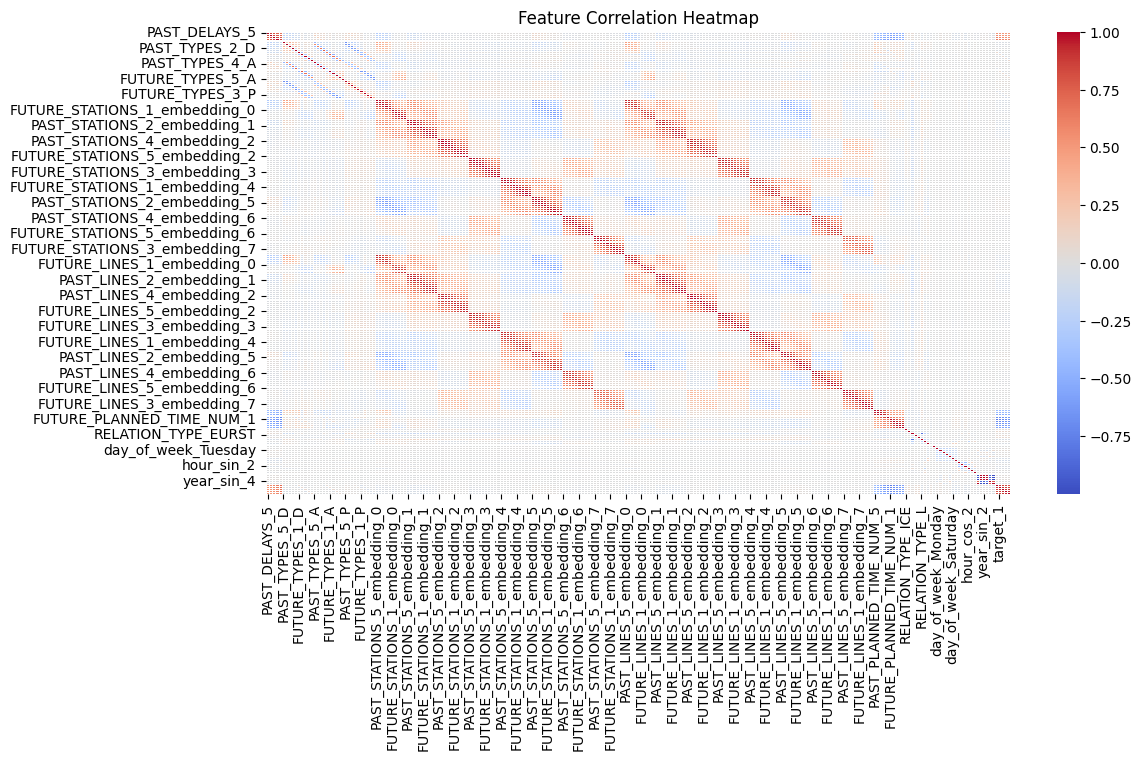

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Target Variable Distribution
Visualizing the distribution of the target variable.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

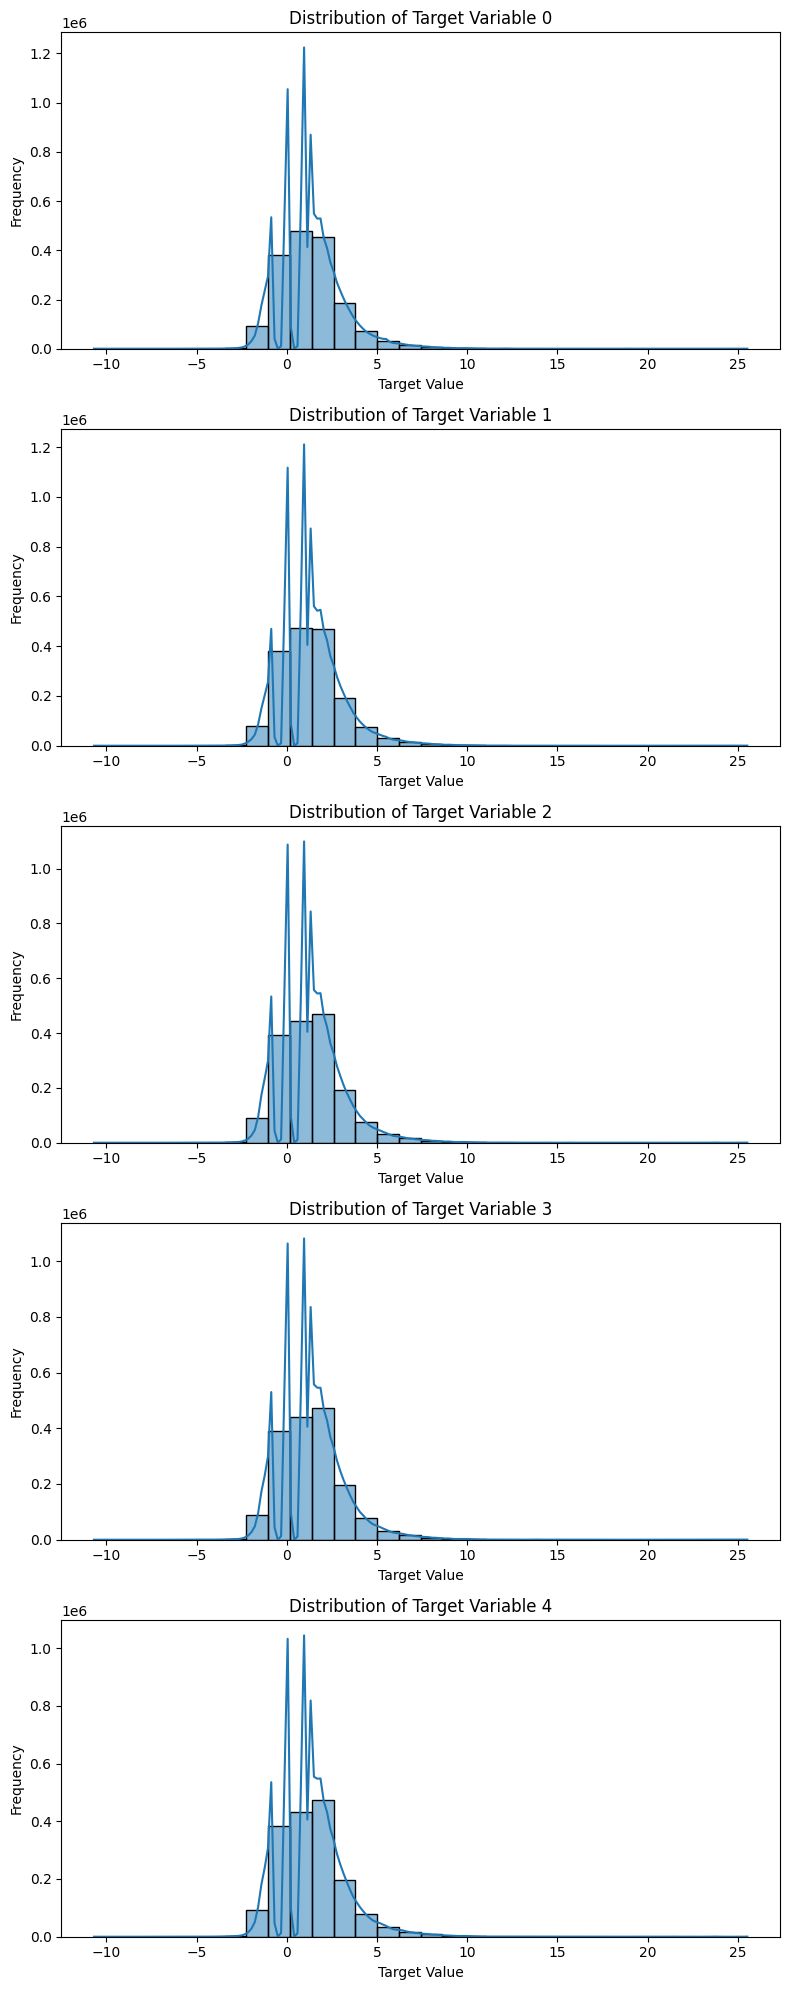

In [ ]:
num_targets = y_delays.shape[1]

fig, axes = plt.subplots(nrows=num_targets, figsize=(8, 4 * num_targets))

for i in range(num_targets):
    sns.histplot(df[f'target_{i}'], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of Target Variable {i}")
    axes[i].set_xlabel("Target Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Outlier Detection
Using boxplots to identify potential outliers in numerical features.

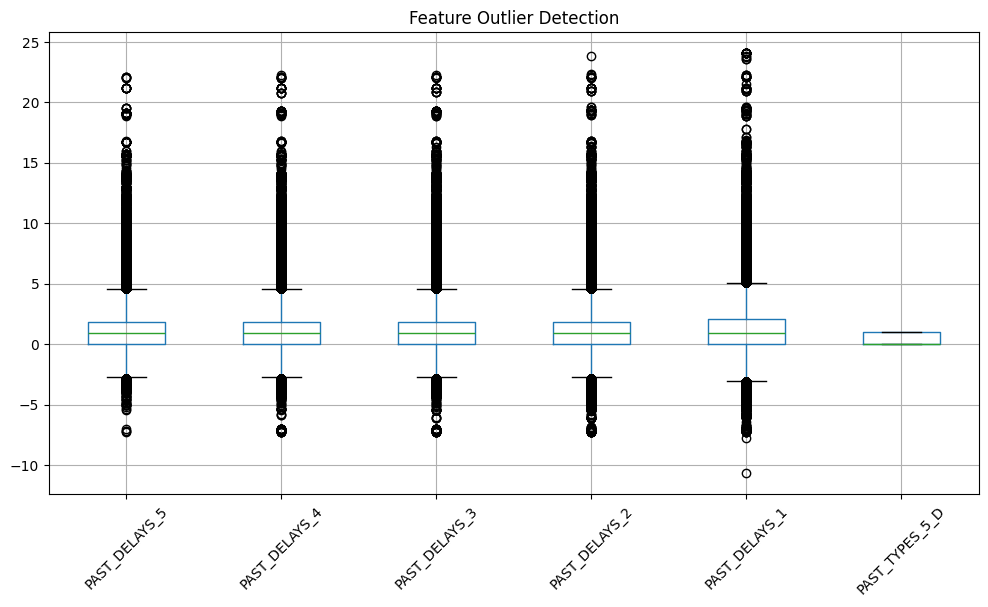

In [ ]:
sample_features = df.select_dtypes(include=['number']).columns[:6] 

plt.figure(figsize=(12, 6))
df[sample_features].boxplot(rot=45)
plt.title("Feature Outlier Detection")
plt.show()

### End of the data visualization. Feel free to explore the other notebooks for details about each model.